In [1]:
## Importing Libraries
from tabulate import tabulate
import time
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#default parameters
plt.rcParams['lines.linewidth'] = 1
import datetime as dt
from functools import reduce
from datetime import datetime, timedelta
# import bamboolib

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

import darts
from darts import concatenate
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.utils.model_selection import train_test_split
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import scaler
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    NaiveMovingAverage,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta,
    XGBModel,
    StatsForecastAutoTheta,
    RNNModel
)
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape,mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
#from darts.utils import GridSearch
from darts.dataprocessing.transformers.boxcox import BoxCox

import xgboost as xgb
from sklearn.metrics import mean_squared_error

import plotly.io as pio


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

t_start1 = time.perf_counter()
%matplotlib inline

#default parameters
plt.rcParams['lines.linewidth'] = 1
MSEAS = 7                     # seasonality default
ALPHA = 0.05                  # significance level default

max_dat = dt.datetime(2017,8,15).date() 
# example timestamp
new_timestamp = max_dat - timedelta(days=60)

print('train data end date:',new_timestamp)
print('validation end date:',max_dat)

TRAIN = new_timestamp                           # training Favorita -60 dagen 

train data end date: 2017-06-16
validation end date: 2017-08-15


In [2]:
print("Darts version:", darts.__version__)
print("Pandas version:", pd.__version__)
# print("Bamboolib version:", bamboolib.__version__)
print("NumPy version:", np.__version__)

Darts version: 0.24.0
Pandas version: 1.5.3
NumPy version: 1.24.3


# Functions

In [3]:
# prepare Naive forecaster

# m_naive = NaiveSeasonal(K=7)
m_naive = NaiveSeasonal(K=1)

In [4]:
m_naivedrift = NaiveDrift()

In [5]:
m_naivemovingaverage = NaiveMovingAverage(input_chunk_length=7)

In [6]:
# prepare Prophet forecaster
m_prophet = Prophet()    #frequency=mseas)

In [7]:
m_theta = Theta()

In [8]:
m_expon = ExponentialSmoothing()

In [9]:
def m_lstm(series): 
#    split series in train and val
    val = series[-60:]
    train = series[-120:-60]

    add_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek','day','week','month','year']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 2013) / 4]}
    }
    my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=60,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="TimeSeries Favorita",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=60,
    force_reset=True,
    save_checkpoints=True,
    add_encoders=add_encoders   
)
    # Normalize the time series (note: we avoid fitting the transformer on the validation set)
    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    series_transformed = transformer.transform(series)
    
    # create month and year covariate series
    year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
                    )
    
    year_series = Scaler().fit_transform(year_series)
    month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
                    )
    covariates = year_series.stack(month_series)
    cov_train, cov_val = covariates.split_after(pd.Timestamp("20170615"))

    my_model.fit(
    train_transformed,
    future_covariates=future_covariate,
    val_series=val_transformed,
    val_future_covariates=None, #future_covariate,
    verbose=True,
)
    # Make predictions on the validation set
    #predict(n, series=None, past_covariates=None, future_covariates=None, num_samples=1, verbose=False, **kwargs)
    predictions = model.predict(len(val),future_covariates=future_covariate)
    res_smape = smape(val, predictions)
    res_rmse = rmse(val, predictions)
    res_mae = mae(val, predictions)
    res_time = time.perf_counter() - t_start

    
    
    
    
# ---------------------Hier voeg ik de BIAS en de NFM toe
    df_val = val.pd_dataframe()                # eerst de val in een dataframe stoppen
#     print(df_val.dtypes)
    df_forecast = predictions.pd_dataframe()      # dan hetzelfde met de forecast
#     print(df_forecast.head())    
    
    #BIAS


#------------- AFHANKELIJK VAN WELK BESTAND JE GEBRUIKT, HIER KIEZEN WELKE REGELS JE GEBRUIKT -------------------
        
#     res_bias = df_forecast["0"].mean() - df_val["0"].mean()                          # Deze bij de store data
    res_bias = df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()      # Deze bij de store_prep data
    # NFM
#     res_nfm = (df_forecast["0"].mean() - df_val["0"].mean()) / (df_forecast["0"].mean() + df_val["0"].mean())
    res_nfm = (df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()) / (df_forecast["unit_sales"].mean() + df_val["unit_sales"].mean())
    
 # --------------------------------------------------------------------------------------------------------------       



    res_accuracy = {
        "SMAPE": "{:.1f}".format(res_smape),
        "RMSE": "{:.1f}".format(res_rmse),   
        "time": "{:.1f}".format(res_time),
        "mae": "{:.1f}".format(res_mae),
        "bias": res_bias,
        "nfm": res_nfm
    }
    
    model_name = type(model).__name__

    
    
    results = [predictions,model_name,res_accuracy]
    # Print the predicted values
#    print(res_mape)
    return(results,train_transformed,val_series,)

In [10]:
#val_series

In [11]:
def m_xgb(series):
    t_start =  time.perf_counter()
    add_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek','day','week','month','year']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 2013) / 4]}
    }
#   Best Lags    
    lags1=[-14, -7, -6, -2, -1]
    lags2=[-30, -14, -7, -6, -2, -1]

    
# XGBModel(lags=None, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, **kwargs)
    # XGBModel(lags=None, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, **kwargs)
    model = XGBModel(lags=lags1, lags_past_covariates=None, lags_future_covariates=lags2, output_chunk_length=1,
                 add_encoders=add_encoders, likelihood=None, quantiles=None,
                 random_state=None, multi_models=True, use_static_covariates=None,
                 max_depth=5,n_estimators=95,learning_rate=0.24
                )
    model_name = type(model).__name__
    
    
    val = series[-60:]
    train = series[:-60]

    # fit(series, past_covariates=None, future_covariates=None, val_series=None, val_past_covariates=None, val_future_covariates=None, max_samples_per_ts=None, **kwargs)
    model.fit(train,future_covariates=future_covariate)

    # Make predictions on the validation set
    #predict(n, series=None, past_covariates=None, future_covariates=None, num_samples=1, verbose=False, **kwargs)
    predictions = model.predict(len(val),future_covariates=future_covariate)
    res_smape = smape(val, predictions)
    res_rmse = rmse(val, predictions)
    res_mae = mae(val, predictions)
    res_time = time.perf_counter() - t_start
    
    
    # ---------------------Hier voeg ik de BIAS en de NFM toe
    df_val = val.pd_dataframe()                # eerst de val in een dataframe stoppen
#     print(df_val.dtypes)
    df_forecast = predictions.pd_dataframe()      # dan hetzelfde met de forecast
#     print(df_forecast.head())

#------------- AFHANKELIJK VAN WELK BESTAND JE GEBRUIKT, HIER KIEZEN WELKE REGELS JE GEBRUIKT -------------------
        
#     res_bias = df_forecast["0"].mean() - df_val["0"].mean()                          # Deze bij de store data
    res_bias = df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()      # Deze bij de store_prep data
    # NFM
#     res_nfm = (df_forecast["0"].mean() - df_val["0"].mean()) / (df_forecast["0"].mean() + df_val["0"].mean())
    res_nfm = (df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()) / (df_forecast["unit_sales"].mean() + df_val["unit_sales"].mean())
    
 # --------------------------------------------------------------------------------------------------------------   

    
    res_accuracy = {
        "SMAPE": "{:.1f}".format(res_smape),
        "RMSE": "{:.1f}".format(res_rmse),   
        "time": "{:.1f}".format(res_time),
        "mae": "{:.1f}".format(res_mae),
        "bias": res_bias,
        "nfm": res_nfm
    }
    
    
    results = [predictions,model_name,res_accuracy]
    # Print the predicted values
#    print(res_mape)
    return(results)


In [12]:
# laundry list of forecasters to run

models = [ 
    #m_naive,
    m_naivedrift,
#     m_naivemovingaverage,
    m_expon, 
#     m_theta, 
    m_prophet,
#     m_arima,
    m_xgb,
#     m_lstm
    ]  

In [13]:
#create a plot 
def plot(series):
    # split in serie in train en validation    
    val = series[-60:]
    train = series[:-60]
    
    plt.figure(101, figsize=(12, 5))
    train.tail(100).plot(label='training',linewidth=1)  #function tail(100) shows the last 100 values of the train set
    val.val.plot(label='validation',linewidth=1)
    forecast.plot(label='forecast',linewidth=5)
   
    plt.title(f'Time Series Plot {store_nbr}-{item_nbr}')
    plt.legend();
    return

In [14]:
def create_series(df_sel,df_cov=None):
    uvar_ts = TimeSeries.from_dataframe(df_sel,time_col='timestamp',value_cols=['unit_sales'],static_covariates=df_cov, freq='D')
    series = uvar_ts   
    return series

In [15]:
def sel_pred_timeseries(item,models=models):
        global df_results
        
        df_sel=df.loc[df['item_nbr'] == item]
#         # create future covariate per item datetime + holiday + promotion
#         df_sel['dayofweek'] = df_sel['timestamp'].dt.dayofweek         
#         df_sel['week'] = df_sel['timestamp'].dt.week   
        
#         fut_cov1 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['day'],static_covariates= None,freq='D', fill_missing_dates=True)
#         fut_cov2 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['year'],static_covariates= None,freq='D', fill_missing_dates=True)
#         fut_cov3 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['month'],static_covariates= None,freq='D', fill_missing_dates=True)
#         fut_cov4 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['week'],static_covariates= None,freq='D', fill_missing_dates=True)
#         fut_cov5 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['dayofweek'],static_covariates= None,freq='D', fill_missing_dates=True)
        
#         fut_cov6 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['onpromotion'],static_covariates= None,freq='D', fill_missing_dates=True)
#         fut_cov7 = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['holiday'],static_covariates= None,freq='D', fill_missing_dates=True)
                
#         from darts import concatenate
#         future_covariate = fut_cov1
#         future_covariate2 = future_covariate.concatenate(fut_cov2, axis=1)
#         future_covariate3 = future_covariate2.concatenate(fut_cov3, axis=1)
#         future_covariate4 = future_covariate3.concatenate(fut_cov4, axis=1)
#         future_covariate5 = future_covariate4.concatenate(fut_cov5, axis=1)
#         future_covariate6 = future_covariate5.concatenate(fut_cov6, axis=1)
#         future_covariate7 = future_covariate6.concatenate(fut_cov7, axis=1)
       
        series = create_series(df_sel)
        
        # check if there are missing values this necessary until the preprocessed parquet files are readable
        df_nan= series.pd_dataframe()
        is_nan =df_nan.isna().values.any()
        if is_nan == True:
            #replace nan values this only works for univariate timeseries
            s = series.pd_series()
            s.replace(0.0, np.nan, inplace=True)
            s = s.fillna(method="bfill")
            uvar_ts=TimeSeries.from_series(s, fill_missing_dates=False, freq='D', fillna_value=None, static_covariates=df_cov)
            series =uvar_ts
            
        train = series[:-60]
        val = series[-60:]
        
        #check the different models, of the model is part of function the eval_model function is passed
        for model in models:
            prediction = []
            if model == m_xgb:
                 prediction= m_xgb(series)
                 prediction = list(prediction)
            elif model == m_lstm:
                prediction = m_lstm(series)
                prediction = list(prediction)
                
            elif model != m_xgb and model != m_lstm:                    # niet xgboost
               prediction = eval_model(model,series)
            
        
       
            prediction.append(item)
            df_results = df_results.append(pd.Series(prediction), ignore_index=True)
            
#               commented this out temporarily V          
#             # Plot it
#             plt.figure(101, figsize=(12, 5))
#             train.tail(100).plot(label='training',linewidth=1)  #function tail(100) shows the last 100 values of the train set
#             val.plot(label='validation',linewidth=1)
#             forecast.plot(label=f'forecast {model}',linewidth=5)
   
#             plt.title(f'Time Series Plot {store_nbr}-{item_nbr} -- {model}')
#             plt.legend()
#             plt.show()
            
    
    

            
#        model_predictions = [eval_model(model,series) for model in models]
#        tabulator(model_predictions)
#        plotter(model_predictions)
        return prediction,item,model,df_results
        

In [16]:
#sel_pred_timeseries(item)

In [17]:
## fit the chosen forecaster model and compute predictions

def eval_model(model,series):
    t_start =  time.perf_counter()
    # split the timeseries in train and val
    val = series[-60:]
    train = series[:-60]

    # fit the model and compute predictions
    res = model.fit(train)
    global forecast
    forecast = model.predict(len(val))

    
#     print(val)                  # quickly print the validation and forecast before the mape is calculated to see why it breaks 
#     print(forecast)
    
    # compute accuracy metrics and processing time
    res_smape = smape(val, forecast)
    res_rmse = rmse(val, forecast)
    res_mae = mae(val, forecast)
    res_time = time.perf_counter() - t_start

    model_name = type(model).__name__
    
# ---------------------Hier voeg ik de BIAS en de NFM toe
    df_val = val.pd_dataframe()                # eerst de val in een dataframe stoppen
#     print(df_val.dtypes)
    df_forecast = forecast.pd_dataframe()      # dan hetzelfde met de forecast
#     print(df_forecast.head())
    
    
    #BIAS


#------------- AFHANKELIJK VAN WELK BESTAND JE GEBRUIKT, HIER KIEZEN WELKE REGELS JE GEBRUIKT -------------------
        
#     res_bias = df_forecast["0"].mean() - df_val["0"].mean()                          # Deze bij de store data
    res_bias = df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()      # Deze bij de store_prep data
    # NFM
#     res_nfm = (df_forecast["0"].mean() - df_val["0"].mean()) / (df_forecast["0"].mean() + df_val["0"].mean())
    res_nfm = (df_forecast["unit_sales"].mean() - df_val["unit_sales"].mean()) / (df_forecast["unit_sales"].mean() + df_val["unit_sales"].mean())
    
 # --------------------------------------------------------------------------------------------------------------   
        
    
    
    
    res_accuracy = {
        "SMAPE": "{:.1f}".format(res_smape),
        "RMSE": "{:.1f}".format(res_rmse),   
        "time": "{:.1f}".format(res_time),
        "mae": "{:.1f}".format(res_mae),
        "bias": res_bias,
        "nfm": res_nfm
    }
   
    

    results = [forecast,model_name,res_accuracy]
    # Append results to the global dataframe

#    print (df_results)
    
# print("completed: " + str(model) + ":" + str(res_time) + "sec"+ str(res_accuracy))
    return results   #,forecast,val,train,model

# Recipe

In [40]:
# 1) Import Library
# 2) Read store data from parquet eliminated are the itermittent and lumpy and other erratic timeseries and the short history products, only perishable, not produce
# 3) Check and add missing dates in the date range
# 4) Create static covariate for DARTS has to be created after selecting itemnumber-store
# 5) Select itemnumber 
# 6) Create past and future covariates
# 7) Create Darts TimeSeries and add static covariate and other covariates
# 8) Additionel check for nan values
# 9) Function plot the observations
#10) Check for seasonality, via ACF
#11) Function split train and test data
#12) Fit the chosen forecaster model and compute predictions from a list of models
#13) Evaluate model performance and chose the best model
#14) 

In [83]:
#2 load data to select the smooth timeseries

## stores 44,11,40,3,28
## items 502331,679926

# Define the store number and item number to filter on
store_nbr = 44
# item_nbr = 129635 #108701 #679926        # item number should be selected later, because not all items are sold in each store

# Define the path to the parquet file for the specified store number
# filename = f'../data/store/store_{store_nbr}.parquet'
filename = f'../../data/store_prep/store_{store_nbr}.parquet'
#Read the parquet file for the specified store number
df = pd.read_parquet(filename)
df_ts=df

item_nbr = df['item_nbr'].iloc[0] # first item number in dataset

In [84]:
# df_ts['unit_sales'].tail(60).min()

In [85]:
# df_ts['unit_sales'].tail(60).describe()

In [86]:
# 3) Check and add missing dates in the date range
##Check for missing dates
end = '2017-08-15'
start = '2013-01-02'
end_date = datetime.strptime(end, '%Y-%m-%d')
start_date = datetime.strptime(start, '%Y-%m-%d')
MissingDates = pd.date_range(start, end).difference(df.timestamp)
print(MissingDates)

time_difference = (end_date - start_date).days
print(time_difference)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)
1686


In [87]:
df

,timestamp,item_nbr,id,store_nbr,unit_sales,onpromotion,day,year,month,family,...,perishable,city,state,type,cluster,forecastability,holiday_local,holiday_regional,holiday_national,holiday
0,2013-01-02,103665,32293,44,20.0,0,2,2013,1,BREAD/BAKERY,...,1,Quito,Pichincha,A,5,smooth,0,0,0,0
1,2013-01-03,103665,72724,44,3.0,0,3,2013,1,BREAD/BAKERY,...,1,Quito,Pichincha,A,5,smooth,0,0,0,0
2,2013-01-04,103665,112570,44,2.0,0,4,2013,1,BREAD/BAKERY,...,1,Quito,Pichincha,A,5,smooth,0,0,0,0
3,2013-01-05,103665,154675,44,16.0,0,5,2013,1,BREAD/BAKERY,...,1,Quito,Pichincha,A,5,smooth,0,0,1,1
4,2013-01-06,103665,196659,44,12.0,0,6,2013,1,BREAD/BAKERY,...,1,Quito,Pichincha,A,5,smooth,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572551,2017-08-11,1977887,125055353,44,5.0,0,11,2017,8,DAIRY,...,1,Quito,Pichincha,A,5,smooth,0,0,1,1
572552,2017-08-12,1977887,125160686,44,6.0,0,12,2017,8,DAIRY,...,1,Quito,Pichincha,A,5,smooth,0,0,0,0
572553,2017-08-13,1977887,125266350,44,12.0,0,13,2017,8,DAIRY,...,1,Quito,Pichincha,A,5,smooth,0,0,0,0
572554,2017-08-14,1977887,125370610,44,9.0,0,14,2017,8,DAIRY,...,1,Quito,Pichincha,A,5,smooth,0,0,0,0


In [88]:
# 4) Create static covariate for DARTS per store
# first the selection of the 'group' of timeseries with the static features has to be made =>features representing store or item group
# 4.1)select the preferred item for creating a static covariate
df_sel=df.loc[df['item_nbr'] == item_nbr]

#       MAPE HACK                  
# ------------------------- REPLACE THE UNIT SALES OF 0 with 0.0001 -------------
# df_sel["unit_sales"] = df_sel["unit_sales"].replace(0,0.00001) 
#--------------------------------------------------------------------------------

df_cov = df_sel[['timestamp','city','state','cluster','type']]
# 4.2)hot encode the categorical features
# Step: OneHotEncode column(s) family
#df_cov = pd.get_dummies(df_cov, columns=['family'], drop_first=False, dummy_na=False)

# 4.3)select the top row as static features keep it as a dataframe
# Step: Keep rows where timestamp == 2013-01-02
df_cov = df_cov.loc[df_cov['timestamp'] == min(df_cov['timestamp'])]


# Step: OneHotEncode column(s) city, state, type
df_cov = pd.get_dummies(df_cov, columns=['city', 'state', 'type'], drop_first=True, dummy_na=False)

df_cov

,timestamp,cluster,type_B,type_C,type_D,type_E
0,2013-01-02,5,0,0,0,0


In [89]:
# 5) Use dataframe for select item_nbr and create uvar and mvar
# Step: Drop columns the 
df_sel1 = df_sel.drop(columns=[ 'family', 'city', 'state', 'type', 'id'])
series = create_series(df_sel1,df_cov)


In [90]:
# check if Timeseries has nan values 
df_series = series.pd_dataframe()
if df_series.isnull().values.any():
    print('there are nan values in series')

In [91]:
# Fill the missing data in the dataframe if needed
df_sel['store_nbr'] = df_sel['store_nbr'].mode()[0] 
#df_sel['item_nbr'] = df_sel['item_nbr'].mode()[0]     # Attention this statement changes all items to mode number
#df_sel['unit_sales'] = df_sel['unit_sales'].mode()[0]   
df_sel['day'] = df_sel['timestamp'].dt.day             # get day from datetime
df_sel['year'] = df_sel['timestamp'].dt.year           # get year from datetime
df_sel['month'] = df_sel['timestamp'].dt.month         # get month from datetime
df_sel['week'] = df_sel['timestamp'].dt.week
df_sel['dayofweek'] = df_sel['timestamp'].dt.dayofweek
df_sel['family'] = df_sel['family'].mode()[0]                 # fill the mode
df_sel['class'] = df_sel['class'].mode()[0]                   # fill the mode
df_sel['perishable'] = 1                                  # fill value
df_sel['city'] = df_sel['city'].mode()[0]                     # fill the mode 
df_sel['state'] = df_sel['state'].mode()[0]                   # fill the mode
df_sel['type'] = df_sel['type'].mode()[0]                     # fill the mode
df_sel['cluster'] = df_sel['cluster'].mode()[0]               # fill the mode      
df_sel['onpromotion'] = df_sel['onpromotion'].mode()[0]
df_sel

,timestamp,item_nbr,id,store_nbr,unit_sales,onpromotion,day,year,month,family,...,state,type,cluster,forecastability,holiday_local,holiday_regional,holiday_national,holiday,week,dayofweek
0,2013-01-02,103665,32293,44,20.0,0,2,2013,1,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,0,0,1,2
1,2013-01-03,103665,72724,44,3.0,0,3,2013,1,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,0,0,1,3
2,2013-01-04,103665,112570,44,2.0,0,4,2013,1,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,0,0,1,4
3,2013-01-05,103665,154675,44,16.0,0,5,2013,1,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,1,1,1,5
4,2013-01-06,103665,196659,44,12.0,0,6,2013,1,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,2017-08-11,103665,125052919,44,8.0,0,11,2017,8,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,1,1,32,4
1683,2017-08-12,103665,125158260,44,7.0,0,12,2017,8,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,0,0,32,5
1684,2017-08-13,103665,125263905,44,4.0,0,13,2017,8,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,0,0,32,6
1685,2017-08-14,103665,125368255,44,4.0,0,14,2017,8,BREAD/BAKERY,...,Pichincha,A,5,smooth,0,0,0,0,33,0


In [92]:
# df_sel.head(20)

In [93]:
# what to do with the categorical values?
# drop categorical value

# convert boolean to value promotion is boolean

# one hot encode 


In [94]:
# create future covariates meaning year,month,day,week
# Create the date range
date_range = pd.date_range(start='2013-01-02', end='2017-08-15')

# Create a DataFrame with the date range as the index
df_fut_cov = pd.DataFrame(index=date_range)

import pandas as pd; import numpy as np
df_fut_cov = df_fut_cov.reset_index()
# Step: Rename column
df_fut_cov = df_fut_cov.rename(columns={'index': 'timestamp'})
df_fut_cov['day'] = df_fut_cov['timestamp'].dt.day             # get day from datetime
df_fut_cov['year'] = df_fut_cov['timestamp'].dt.year           # get year from datetime
df_fut_cov['month'] = df_fut_cov['timestamp'].dt.month         # get month from datetime
df_fut_cov['week'] = df_fut_cov['timestamp'].dt.week
df_fut_cov['dayofweek'] = df_fut_cov['timestamp'].dt.dayofweek


fut_cov1 = TimeSeries.from_dataframe(df_fut_cov, time_col='timestamp',value_cols=['day'],static_covariates= None,freq='D', fill_missing_dates=True)
fut_cov2 = TimeSeries.from_dataframe(df_fut_cov, time_col='timestamp',value_cols=['year'],static_covariates= None,freq='D', fill_missing_dates=True)
fut_cov3 = TimeSeries.from_dataframe(df_fut_cov, time_col='timestamp',value_cols=['month'],static_covariates= None,freq='D', fill_missing_dates=True)
fut_cov4 = TimeSeries.from_dataframe(df_fut_cov, time_col='timestamp',value_cols=['week'],static_covariates= None,freq='D', fill_missing_dates=True)
fut_cov5 = TimeSeries.from_dataframe(df_fut_cov, time_col='timestamp',value_cols=['dayofweek'],static_covariates= None,freq='D', fill_missing_dates=True)

#fut_cov
#future_covariates = future_covariates.stack(df_fut_cov['day'],df_fut_cov['year'],df_fut_cov['month'],df_fut_cov['week'])

from darts import concatenate
future_covariate = fut_cov1
future_covariate2 = future_covariate.concatenate(fut_cov2, axis=1)
future_covariate3 = future_covariate2.concatenate(fut_cov3, axis=1)
future_covariate4 = future_covariate3.concatenate(fut_cov4, axis=1)
future_covariate5 = future_covariate4.concatenate(fut_cov5, axis=1)



# future_covariate = concatenate([fut_cov1], axis=1) #,fut_cov2,fut_cov3,fut_cov4 
# future_covariate = concatenate([fut_cov2], axis=1)
# future_covariate = concatenate([fut_cov3], axis=1)
# future_covariate = concatenate([fut_cov4], axis=1)
# future_covariate = concatenate([fut_cov5], axis=1)

In [95]:
#create the Darts TimeSeries form the updated dataframe 

#create multivariate timeseries
#mvar_ts = TimeSeries.from_dataframe(df_sel, time_col='timestamp', static_covariates= df_cov ,freq='D', fill_missing_dates=True)
#series=mvar_ts
#create univariate timeseries
uvar_ts = TimeSeries.from_dataframe(df_sel, time_col='timestamp',value_cols=['unit_sales'] ,static_covariates= None,freq='D', fill_missing_dates=True)
series=uvar_ts


In [96]:
#replace nan values this only works for univariate timeseries
#series=uvar_ts
s = series.pd_series()
s.replace(0.0, np.nan, inplace=True)
s = s.fillna(method="bfill")
uvar_ts=TimeSeries.from_series(s, fill_missing_dates=False, freq='D', fillna_value=None, static_covariates=df_cov)
series=uvar_ts

In [97]:
#Check for nan values
df_nan= series.pd_dataframe()
df_nan.isna().values.any()

False

In [98]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))
    


seasonal? True
There is seasonality of order 7.


# #12.1 Select the itemnumbers to forecast

In [99]:
unique_items = df_ts['item_nbr'].unique()

In [100]:
print(f"There are {len(unique_items)} unique items..")
items_to_model = input(" How many items should we predict? : ")

There are 388 unique items..
 How many items should we predict? : 388


In [101]:
items_to_model = int(items_to_model)

In [102]:
unique_items = df_ts['item_nbr'].unique()
first_n_items = unique_items[:items_to_model]

# first_5_items = unique_items[:5]
# lst = list(first_5_items)

lst = list(first_n_items)
lst
# lst=[329397]
 
# lst

[103665,
 108701,
 129635,
 153239,
 153395,
 158680,
 158842,
 164088,
 173113,
 208384,
 227111,
 258268,
 310644,
 311994,
 319093,
 319094,
 329397,
 360314,
 376427,
 378685,
 420720,
 452212,
 457424,
 457425,
 457928,
 468058,
 471985,
 502182,
 502331,
 507478,
 507479,
 517903,
 519560,
 552050,
 557256,
 557257,
 557285,
 557408,
 558730,
 559044,
 567778,
 567781,
 578097,
 582863,
 582864,
 583795,
 583797,
 583799,
 583868,
 583925,
 583931,
 583968,
 583973,
 584026,
 584028,
 584076,
 584078,
 584188,
 617092,
 623316,
 634009,
 634010,
 634014,
 634054,
 660503,
 671051,
 671076,
 671079,
 671083,
 671684,
 671699,
 699693,
 699703,
 723184,
 723210,
 732007,
 752987,
 758861,
 765092,
 789905,
 809183,
 819206,
 819209,
 819231,
 823245,
 828632,
 838215,
 838216,
 838217,
 838406,
 838407,
 838408,
 839544,
 839545,
 841197,
 844017,
 844019,
 847894,
 849098,
 860548,
 862213,
 882624,
 888689,
 939207,
 953427,
 953428,
 954553,
 957098,
 1014865,
 1038952,
 1044592

# #12.2 Final code to iterate over the items per store 

In [103]:
# use list of items to iterate over for store 44
#create global dataframe
df_results = pd.DataFrame()

for i, item in enumerate(lst):
    try:
        sel_pred_timeseries(item)
        print(f"Iteration {i+1}: store {store_nbr }, item {item} is done")
    except Exception as e:
         print(f"Iteration {i+1}: store {store_nbr }, the code broke on item {item}: {e}")

print(f'\n THE END')

Iteration 1: store 44, item 103665 is done
Iteration 2: store 44, item 108701 is done
Iteration 3: store 44, item 129635 is done
Iteration 4: store 44, item 153239 is done
Iteration 5: store 44, item 153395 is done
Iteration 6: store 44, item 158680 is done
Iteration 7: store 44, item 158842 is done
Iteration 8: store 44, item 164088 is done
Iteration 9: store 44, item 173113 is done
Iteration 10: store 44, item 208384 is done
Iteration 11: store 44, item 227111 is done
Iteration 12: store 44, item 258268 is done
Iteration 13: store 44, item 310644 is done
Iteration 14: store 44, item 311994 is done
Iteration 15: store 44, item 319093 is done
Iteration 16: store 44, item 319094 is done
Iteration 17: store 44, item 329397 is done
Iteration 18: store 44, item 360314 is done
Iteration 19: store 44, item 376427 is done
Iteration 20: store 44, item 378685 is done
Iteration 21: store 44, item 420720 is done
Iteration 22: store 44, item 452212 is done
Iteration 23: store 44, item 457424 is do

Iteration 186: store 44, item 838413 is done
Iteration 187: store 44, item 838415 is done
Iteration 188: store 44, item 841667 is done
Iteration 189: store 44, item 849142 is done
Iteration 190: store 44, item 849312 is done
Iteration 191: store 44, item 859966 is done
Iteration 192: store 44, item 866927 is done
Iteration 193: store 44, item 870938 is done
Iteration 194: store 44, item 888682 is done
Iteration 195: store 44, item 888761 is done
Iteration 196: store 44, item 888763 is done
Iteration 197: store 44, item 903285 is done
Iteration 198: store 44, item 903286 is done
Iteration 199: store 44, item 913526 is done
Iteration 200: store 44, item 915810 is done
Iteration 201: store 44, item 939130 is done
Iteration 202: store 44, item 939210 is done
Iteration 203: store 44, item 967021 is done
Iteration 204: store 44, item 983310 is done
Iteration 205: store 44, item 986193 is done
Iteration 206: store 44, item 991114 is done
Iteration 207: store 44, item 996606 is done
Iteration 

Iteration 366: store 44, item 1914782 is done
Iteration 367: store 44, item 2002136 is done
Iteration 368: store 44, item 1932980 is done
Iteration 369: store 44, item 1940466 is done
Iteration 370: store 44, item 1940454 is done
Iteration 371: store 44, item 1940026 is done
Iteration 372: store 44, item 1944828 is done
Iteration 373: store 44, item 1944334 is done
Iteration 374: store 44, item 1948161 is done
Iteration 375: store 44, item 1957078 is done
Iteration 376: store 44, item 1962824 is done
Iteration 377: store 44, item 1963277 is done
Iteration 378: store 44, item 1971328 is done
Iteration 379: store 44, item 1971373 is done
Iteration 380: store 44, item 1971394 is done
Iteration 381: store 44, item 1977901 is done
Iteration 382: store 44, item 1977997 is done
Iteration 383: store 44, item 1978835 is done
Iteration 384: store 44, item 1981470 is done
Iteration 385: store 44, item 1989798 is done
Iteration 386: store 44, item 1990742 is done
Iteration 387: store 44, item 1998

In [104]:
#make nice result frame
df_results.columns = [str(column) for column in df_results.columns]
# Step: Rename multiple columns
df_results_n = df_results.rename(columns={'0': 'Forecast', '1': 'Model', '2': 'Accuracy', '3': 'Item'})
# Step: Rearranged the order of the columns
df_results_nm = df_results_n[['Item'] + ['Forecast', 'Model', 'Accuracy']]
# Step: Rearranged the order of the columns
df_results_nmf = df_results_nm[['Item', 'Model', 'Accuracy'] + ['Forecast']]

df_results_nmf

,Item,Model,Accuracy,Forecast
0,103665,NaiveDrift,"{'SMAPE': '58.5', 'RMSE': '6.4', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
1,103665,ExponentialSmoothing,"{'SMAPE': '44.5', 'RMSE': '4.6', 'time': '0.3'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
2,103665,Prophet,"{'SMAPE': '47.1', 'RMSE': '4.9', 'time': '0.7'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
3,103665,XGBModel,"{'SMAPE': '46.4', 'RMSE': '5.1', 'time': '0.5'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
4,108701,NaiveDrift,"{'SMAPE': '54.6', 'RMSE': '3.1', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
...,...,...,...,...
1547,1998005,XGBModel,"{'SMAPE': '23.2', 'RMSE': '15.8', 'time': '0.5...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
1548,1977887,NaiveDrift,"{'SMAPE': '95.6', 'RMSE': '8.0', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
1549,1977887,ExponentialSmoothing,"{'SMAPE': '45.2', 'RMSE': '4.6', 'time': '0.2'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."
1550,1977887,Prophet,"{'SMAPE': '45.6', 'RMSE': '4.7', 'time': '0.3'...","(((<TimeSeries (DataArray) (timestamp: 1, comp..."


## 12.3 Put the accuracy metrics in their own columns

In [105]:
# Create new columns by splitting the "Accuracy" column
df_results_nmf[['SMAPE', 'RMSE', 'time', 'mae', 'bias', 'nfm']] = df_results_nmf['Accuracy'].apply(pd.Series)

In [106]:
df_results_nmf.head(10)

,Item,Model,Accuracy,Forecast,SMAPE,RMSE,time,mae,bias,nfm
0,103665,NaiveDrift,"{'SMAPE': '58.5', 'RMSE': '6.4', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",58.5,6.4,0.0,5.5,4.068697,0.187768
1,103665,ExponentialSmoothing,"{'SMAPE': '44.5', 'RMSE': '4.6', 'time': '0.3'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",44.5,4.6,0.3,3.7,-0.033703,-0.001919
2,103665,Prophet,"{'SMAPE': '47.1', 'RMSE': '4.9', 'time': '0.7'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",47.1,4.9,0.7,3.9,-0.584126,-0.034328
3,103665,XGBModel,"{'SMAPE': '46.4', 'RMSE': '5.1', 'time': '0.5'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",46.4,5.1,0.5,3.9,0.823946,0.044721
4,108701,NaiveDrift,"{'SMAPE': '54.6', 'RMSE': '3.1', 'time': '0.0'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",54.6,3.1,0.0,2.1,-0.236799,-0.028890
5,108701,ExponentialSmoothing,"{'SMAPE': '64.4', 'RMSE': '3.2', 'time': '0.4'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",64.4,3.2,0.4,2.2,-1.285704,-0.179878
6,108701,Prophet,"{'SMAPE': '56.7', 'RMSE': '2.8', 'time': '0.5'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",56.7,2.8,0.5,2.1,-0.272988,-0.033453
7,108701,XGBModel,"{'SMAPE': '63.2', 'RMSE': '3.2', 'time': '0.5'...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",63.2,3.2,0.5,2.4,-0.294311,-0.036161
8,129635,NaiveDrift,"{'SMAPE': '35.1', 'RMSE': '18.8', 'time': '0.0...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",35.1,18.8,0.0,16.7,13.610516,0.134922
9,129635,ExponentialSmoothing,"{'SMAPE': '17.7', 'RMSE': '10.1', 'time': '0.3...","(((<TimeSeries (DataArray) (timestamp: 1, comp...",17.7,10.1,0.3,7.8,1.437472,0.016205


## 12.4 Calculate the scores per model (aggregated over all forecasted items)

In [107]:
# turn them to floats so we can sum the scores
df_results_nmf['SMAPE'] = df_results_nmf['SMAPE'].astype(float) # -------------------- DEZE IS UITGEZET OMDAT HIJ NIET BEREKEND KON WORDEN
df_results_nmf['RMSE'] = df_results_nmf['RMSE'].astype(float)
df_results_nmf['time'] = df_results_nmf['time'].astype(float)
df_results_nmf['mae'] = df_results_nmf['mae'].astype(float)
df_results_nmf['bias'] = df_results_nmf['bias'].astype(float)
df_results_nmf['nfm'] = df_results_nmf['nfm'].astype(float)

In [108]:
df_results_nmf['Item'] = df_results_nmf['Item'].astype(str)  # Convert "Item" column to string
df_results_nmf['Model'] = df_results_nmf['Model'].astype(str)  # Convert "Model" column to string

In [109]:



grouped_df_results = df_results_nmf.groupby('Model').agg({'SMAPE': 'mean', # -------------------- DEZE IS UITGEZET OMDAT HIJ NIET BEREKEND KON WORDEN

                                                          'RMSE': 'mean',
                                                          'time': 'mean',
                                                          'mae': 'mean',
                                                          'bias': 'mean',
                                                          'nfm': 'mean'}).reset_index()

In [110]:
#Capture the baseline model SMAPE score
baseline = grouped_df_results.loc[grouped_df_results['Model'] == 'NaiveDrift', 'SMAPE'].iloc[0]

#create a new column (improvement) that captures the difference between model and baseline model
grouped_df_results['Improvement'] = 1 - (grouped_df_results['SMAPE'] / baseline)

# Step: Rearranged the order of the columns
grouped_df_results = grouped_df_results[['Improvement'] + ['Model', 'SMAPE', 'RMSE', 'time', 'mae', 'bias', 'nfm']]

grouped_df_results

,Improvement,Model,SMAPE,RMSE,time,mae,bias,nfm
0,0.287526,ExponentialSmoothing,45.354639,7.790206,0.389948,6.262887,1.231248,0.014761
1,0.000000,NaiveDrift,63.657990,12.733247,0.044845,10.940464,4.572683,0.008832
2,0.253971,Prophet,47.490722,7.653351,0.575515,6.055412,0.037585,-0.019419
3,0.250376,XGBModel,47.719588,8.388660,0.623196,6.648711,1.319245,0.030248


### Make visual of the perfomance of the models

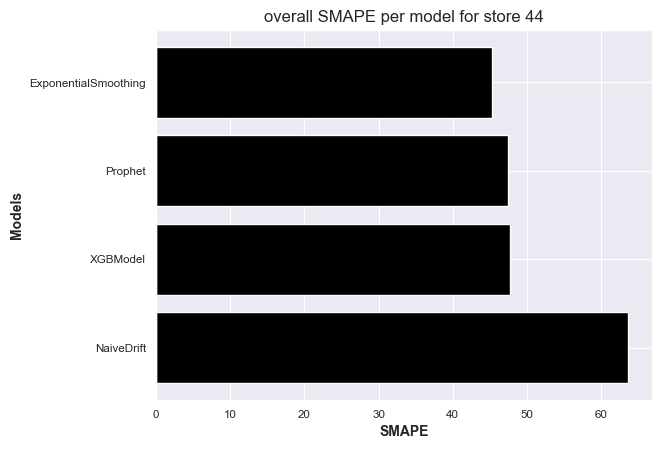

In [111]:
plt.barh(grouped_df_results.sort_values(by='Improvement', ascending=True)["Model"],
         grouped_df_results.sort_values(by='Improvement', ascending=True)["SMAPE"])

# setting label of y-axis
plt.ylabel("Models")
 
# setting label of x-axis
plt.xlabel("SMAPE")
plt.title(f"overall SMAPE per model for store {store_nbr}")

# save the plot
plt.savefig(f'../../data/modeling_results_plotted/store_{store_nbr}_best_performing_models.png')

plt.show()




### Capture the best model for this store, and show the improvement over the Naive model

In [112]:
#capture the best model name
best_model = grouped_df_results.sort_values(by='Improvement', ascending=False).loc[0, "Model"]
#capture the best model's improvement
best_model_improvement = grouped_df_results.sort_values(by='Improvement', ascending=False).loc[0, "Improvement"]


# Print message stating which model is the best, and how it compares to naive
print(f"The best model for store {store_nbr} is {best_model}")
print(f"the improvement over the Naive model is  {round(best_model_improvement * 100,2)}%")


The best model for store 44 is ExponentialSmoothing
the improvement over the Naive model is  28.75%


## Save the forecasts to dataframe and write as excel file

In [113]:
#Reduce the dataframe to only include the best performing model (== model selection is dynamic, best model is selected based on overall lowest SMAPE)
best_df_results_nmf = df_results_nmf.loc[df_results_nmf['Model'] == best_model]

In [114]:
# Initialize an empty DataFrame with the desired columns:  item, model and 60 days ahead forecasts
forecast_df = pd.DataFrame(columns=["Item", "Model"] + [f"day_t+{i}" for i in range(1, 61)])

In [115]:
# Iterate over each row in the original DataFrame and extract the forecasts from the series objects:

for index, row in best_df_results_nmf.iterrows():
    Item = row["Item"]
    Model = row["Model"]
    Forecast_series = row["Forecast"].pd_dataframe()
    Forecast_series = Forecast_series["unit_sales"]
    
    # Extract the forecasts from the series object as a list
    forecasts = Forecast_series.to_list()
    
    # Create a new row with item, model, and the forecasts for each day
    new_row = {"Item": Item, "Model": Model}
    for i in range(len(forecasts)):
        new_row[f"day_t+{i+1}"] = forecasts[i]
    
    # Append the new row to the new DataFrame
    forecast_df = forecast_df.append(new_row, ignore_index=True)

# print(forecast_df.head())

# best_df_results_nmf["Forecast"]

In [116]:
# forecast_df

#### Write this dataframe to excel for use by the store managers

In [117]:
# Save the forecasts to file folder on Github
forecast_df.to_excel(f'../../data/forecasted_unit_sales/store_{store_nbr}_forecasts.xlsx', index=False)


## 12.5  Plot the performance of the modeled timeseries

in the second cell of this paragraph, please specify which model you want to plot.
The first cell will show the possible options.

In [118]:
# print("Choose which of the folowing model(s) you want to plot")
# print(df_results_nmf['Model'].unique())

In [119]:
# model_to_plot = input("Which of the above models would you like to see? : ")
model_to_plot = best_model   # We plot the best performing model
naivemodel = NaiveDrift      # define the naive model

In [120]:
naive_model_df = df_results_nmf[df_results_nmf['Model'] == "NaiveDrift"]

In [121]:
single_model_df = df_results_nmf[df_results_nmf['Model'] == model_to_plot]

In [122]:
import seaborn as sns

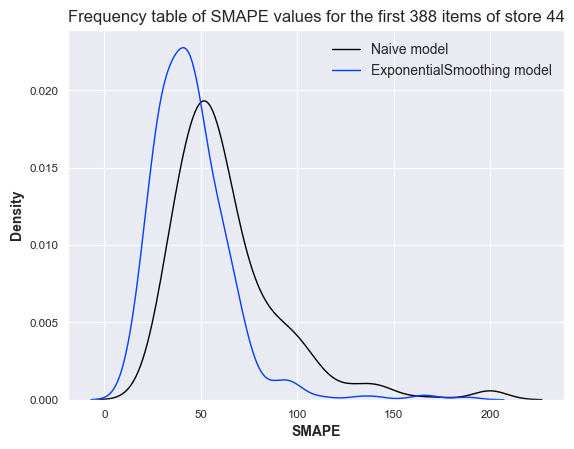

In [123]:
sns.set_style('darkgrid')

# Create a new figure and axis
fig, ax = plt.subplots()

# Overlay the first graph
sns.kdeplot(naive_model_df["SMAPE"], ax=ax, label=f'Naive model')

# Overlay the second graph
sns.kdeplot(single_model_df["SMAPE"], ax=ax, label=f'{model_to_plot} model')

# Set the title and legend
ax.set(title=f'Frequency table of SMAPE values for the first {items_to_model} items of store {store_nbr}')
ax.legend()

# Save the figure as PNG
plt.savefig(f'../../data/modeling_results_plotted/store_{store_nbr}_SMAPE_frequencyplot.png', dpi=300)

In [124]:
# sns.set_style('darkgrid')

# sns.distplot(naive_model_df["SMAPE"]).set(title=f'Frequency table of SMAPE values of {NaiveSeasonal()} model, for the first {items_to_model} items of store {store_nbr}')
# sns.distplot(single_model_df["SMAPE"]).set(title=f'Frequency table of SMAPE values of {model_to_plot} model (blue) \n vs Naive model (grey), \n for the first {items_to_model} items of store {store_nbr}')


## To do:

* ~De forecasts wegschrijven in een excel file voor de supermarkt managers~
* Visual van 1 of 2 forecast maken
* ~Visual van improvements (barchart)~
* ~Dynamisch het beste model selecteren en de SMAPE plotten in frequentie grafiek t.o.v. naive~
* OUTLIERS verwijderen in bestand Joost


/n

* Code opschonen
* Code beschrijven in Markdown en comments
